<a href="https://colab.research.google.com/github/ibrahimabdike/FinanceTrainML/blob/master/FinancTrainMLPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
amz = pd.read_csv("/content/AMZ.csv")
amz.head()

,Date,AdjClose,Close,High,Low,Open,Volume
0,2019-09-20,1794.16,1794.16,1830.6300,1781.0,1821.71,4324478
1,2019-09-19,1821.50,1821.50,1832.5699,1817.9,1821.02,2031500
2,2019-09-18,1817.46,1817.46,1822.0601,1795.5,1817.04,2505600
3,2019-09-17,1822.55,1822.55,1823.9900,1804.1,1807.08,1982400
4,2019-09-16,1807.84,1807.84,1825.6899,1800.2,1824.02,3675500


In [0]:
amz.tail()

,Date,AdjClose,Close,High,Low,Open,Volume
5028,1999-09-27,62.5625,62.563,67.875,61.8750,66.188,14383100
5029,1999-09-24,65.0000,65.000,66.000,61.5049,62.000,10972500
5030,1999-09-23,62.2500,62.250,68.750,61.2340,67.000,14373600
5031,1999-09-22,66.0000,66.000,66.500,60.6859,62.875,10037500
5032,1999-09-21,62.2500,62.250,63.938,61.0000,61.625,8232500


In [0]:
def get_technical_indicators(dataset):
    '''
    params:
        dataset: OHLCV data for AMZ ticker from 1999-09-01 to 2019-09-20
    returns    
        features dataframe with the calculations of all technical Indicators such as 
        MACD, 20 period’s standard deviation, ROC, CCI, EMA
    '''
    # Sort values by dates. Old dates at top 
    dataset.sort_index(inplace=True)
    # Create the features  dataframe to store only the features
    features = pd.DataFrame(index=dataset.index)
    
    # Create 7 and 21 days Moving Average
    features['ma7'] = dataset['AdjClose'].rolling(window=7).mean()
    features['ma21'] = dataset['AdjClose'].rolling(window=21).mean()
    
    # Create MACD
    features['26ema'] = dataset['AdjClose'].ewm(span=26).mean()
    features['12ema'] = dataset['AdjClose'].ewm(span=12).mean()
    features['MACD'] = (features['12ema']-features['26ema'])
 
    # Create Bollinger Bands
    features['20sd'] = dataset['AdjClose'].rolling(20).std()
    features['upper_band'] = features['ma21'] + (features['20sd']*2)
    features['lower_band'] = features['ma21'] - (features['20sd']*2)
    
    # Create Exponential moving average
    features['ema'] = dataset['AdjClose'].ewm(span=20).mean()
    
    # ROC Rate of Change
    N = dataset['AdjClose'].diff(10)
    D = dataset['AdjClose'].shift(10)
    features['ROC'] = N/D
    
    # CCI  Commodity Channel Index
    TP = (dataset['High'] + dataset['Low'] + dataset['AdjClose']) / 3 
    features['CCI']  = (TP - TP.rolling(20).mean()) / (0.015 *  TP.rolling(20).std() )
    # Create Average True Range 
    features['TR'] = dataset['High'] - dataset['Low']
    features['ATR'] = features['TR'].ewm(span = 10).mean()
 
    return features
 
 
# Store the output of get_technical_indicators() function in the features object
 
features = get_technical_indicators(amz)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

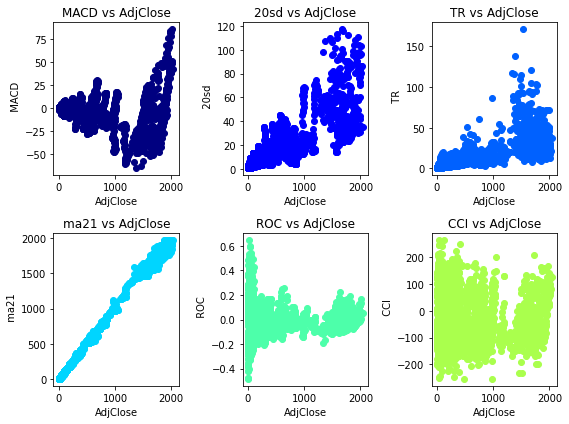

In [0]:
# Retrieve the features that will be used  in the vars_ dataframe
vars_ = features[['MACD','20sd','TR','ma21','ROC','CCI']]
 
# The correlation() function would make scatterplots between each of the features and  the target variable AdjClose
 
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,10)))
 
def correlation(df,features,variables, n_rows, n_cols):
    fig = plt.figure(figsize=(8,6))
    #fig = plt.figure(figsize=(14,9))
    for i, var in enumerate(variables):
        ax = fig.add_subplot(n_rows,n_cols,i+1)
        asset = features.loc[:,var]
        ax.scatter(df["AdjClose"], asset, c = next(colors))
        ax.set_xlabel("AdjClose")
        ax.set_ylabel("  {}".format(var))
        ax.set_title(var +" vs AdjClose")
    fig.tight_layout() 
    plt.show()
        
columns = vars_.columns    
correlation(amz,vars_,columns,2,3)

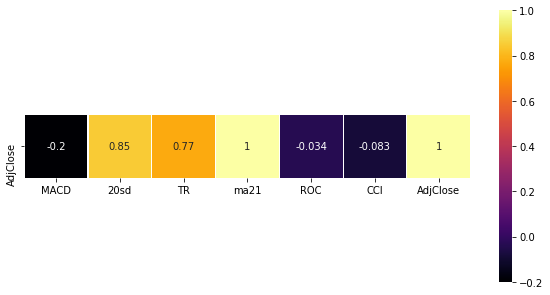

In [0]:
# Copy the vars_ dataframe into a new dataframe called df. 
# Add the target variable to the vars_ dataframe to make a correlation matrix among  features and target variable. Finally show a Heat Map with the values of the correlation matrix.
 
df = vars_.copy()
df['AdjClose'] = amz['AdjClose']
 
colormap = plt.cm.inferno
plt.figure(figsize=(10,5))
corr = df.corr()
sns.heatmap(corr[corr.index == 'AdjClose'], linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);
plt.show()

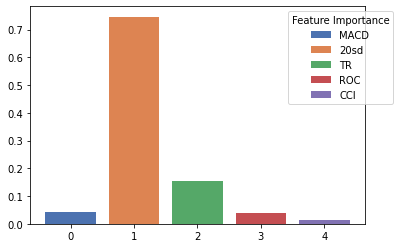

In [0]:
# Fit Random Forest Regressor and extract feature importance
prices = pd.DataFrame(amz['AdjClose'])
vars_model = prices.join(vars_)
vars_model= vars_model.dropna()
 
X = vars_model[['MACD','20sd','TR','ROC','CCI']].values
y = vars_model['AdjClose'].values
 
forest = RandomForestRegressor(n_estimators=1000)
forest = forest.fit(X, y)
importances = forest.feature_importances_
 
values = list(zip(vars_model.columns[1:],importances))
headers = ['feature','score']
values_df = pd.DataFrame(values,columns = headers)
 
# Plot the feature importance
columns = ['MACD','20sd','TR','ROC','CCI']
nd = np.arange(len(columns))
width=0.5
fig = plt.bar(nd, values_df['score'].values, color=sns.color_palette("deep", 5))
plt.legend(fig, columns, loc = 'upper right',bbox_to_anchor=(1.1, 1), title = "Feature Importance")
plt.show()